In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import optimize
from tqdm import tqdm
import os 
import pandas as pd 
from misc import *
from scipy import optimize


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from agent import Agent

In [57]:
agent =Agent(channel={"class":"compound_lossy", "params":[0.5, 0.01]})
def success_probability_2L(betas, amplitude=0.4):
    b0, b1 ,b2 = betas
    p=0
    for n1,n2 in zip([0,0,1,1],[0,1,0,1]):
        ph = [-1,1][np.argmax([agent.PP(ph*amplitude, b0 ,1/np.sqrt(2), n1)*agent.PP(ph*amplitude, [b1,b2][n1] ,1/np.sqrt(2), n2) for ph in [-1,1]])]
        for att in [0.01, 1]:
            p+=agent.P(np.sqrt(att)*ph*amplitude, b0 ,1/np.sqrt(2), n1)*agent.P(np.sqrt(att)*ph*amplitude, [b1,b2][n1] ,1/np.sqrt(2), n2)/4
    return -p

In [58]:
amplitudes = np.linspace(.4, 5,10)
optvals = np.zeros(len(amplitudes))
optbetas = np.zeros((len(amplitudes), 3))
for inda, a in enumerate(tqdm(amplitudes)):
    blim = 2*a
    f=optimize.dual_annealing(success_probability,([(-blim,blim)])*3, args=[a], maxiter=5000,no_local_search=True )
    optvals[inda] = -f.fun
    optbetas[inda] = f.x

100%|██████████| 10/10 [01:37<00:00,  9.78s/it]


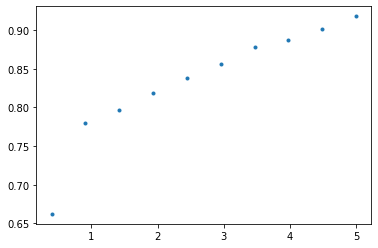

In [41]:
plt.plot(amplitudes,optvals,'.')

In [ ]:
agent =Agent(channel={"class":"compound_lossy", "params":[0.5, 0.01]})
def success_probability_3L(betas, amplitude=0.4,L=3):
    b0, b1 ,b2, b4, b5, b6 = betas
    p=0
    for n1,n2,n3 in zip(*misc.outcomes_universe(3).T):
        ph = [-1,1][np.argmax([agent.PP(ph*amplitude, b0 ,1/np.sqrt(L), n1)*agent.PP(ph*amplitude, [b1,b2][n1] ,1/np.sqrt(2), n2)*agent.PP(ph*amplitude, np.array([[b3,b4],[b5,b6]])[n1,n2] ,1/np.sqrt(L), n3) for ph in [-1,1]])]
        for att in [0.01, 1]:
            p+=agent.P(np.sqrt(att)*ph*amplitude, b0 ,1/np.sqrt(L), n1)*agent.P(np.sqrt(att)*ph*amplitude, [b1,b2][n1] ,1/np.sqrt(L), n2)*agent.PP(ph*amplitude, np.array([[b3,b4],[b5,b6]])[n1,n2] ,1/np.sqrt(L), n3) /4
    return -p

In [55]:
success_probability_2L([3,4,1])

0 0 0
0 0 1
0 1 0
0 1 1
1 0 0
1 0 1
1 1 0
1 1 1


-1.223447098857284

array([[0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 0, 1]])

In [2]:


class InterpolationModel:
    def __init__(self, priors, labels):
        self.model = interp1d(priors, labels)
    def __call__(self, unseen_point):
        if unseen_point < .5:
            return self.model(1-unseen_point)
        else:
            return self.model(unseen_point)

class RewardModel():
    def __init__(self):
        pass
    def R_function(self,postirior_plus):
        reward = np.max([postirior_plus, 1-postirior_plus])
        return reward
    def __call__(self,postiriors):
        return self.R_function(postiriors)



class SuccessProbability():
    def __init__(self, n_phases=2,amplitude=0.4, prob_ep=0.5, ep=1):
        self.n_phases = n_phases
        self.amplitude = amplitude
        self.possible_phases = np.array([-1.,1.])
        self.ep=ep
        self.prob_ep = prob_ep
        
    def NProb(self,outcome, amp,beta):
        p0=0
        for pep, ep in zip([self.prob_ep, 1-self.prob_ep],[self.ep, 1]):
            p0+= pep*np.exp(-abs(complex(np.sqrt(ep)*amp)+complex(beta))**2)
        if outcome == 0.:
            return p0
        else:
            return 1-p0

    def outcome_probability(self,outcome,prior_plus,beta,amp):
        prs = [prior_plus, 1-prior_plus]
        p=0
        for phase,pr in zip([1,-1], prs):
            p+= pr*self.NProb(outcome,phase*amp,beta)
        return p

    def postirior_probability(self,outcome, prior_plus, beta, amp):
        prob_ot = self.outcome_probability(outcome, prior_plus, beta, amp)
        return prior_plus*self.NProb(outcome, amp,beta)/prob_ot

    def J_intermmediate(self, prior_plus, beta, amplitude,next_J_interpolation):
        objective_function = 0
        for outcome in [0, 1]:
            postirior_plus = self.postirior_probability(outcome, prior_plus, beta, amplitude)
            objective_function += next_J_interpolation(postirior_plus)*self.outcome_probability(outcome, prior_plus, beta, amplitude)
        return -objective_function

for number_photodetectors in range(36,50):

    amplitude = .4
    ep=0.01
    suc = SuccessProbability(amplitude=amplitude/np.sqrt(number_photodetectors), prob_ep=.5, ep=ep)

    Npriors = 100
    priors = np.linspace(.5,1,Npriors)

    objective_functions = np.zeros((number_photodetectors+1,len(priors)))
    displacements = np.zeros((number_photodetectors,len(priors)))


    ### last layer ###
    modelito = RewardModel()
    for indp, pr in enumerate(priors):
        objective_functions[number_photodetectors, indp] = modelito(pr)

    for layer in tqdm(range(number_photodetectors)[::-1]):
        if layer == number_photodetectors-1:
            eff_amplitude=amplitude/np.sqrt(number_photodetectors)
        else:
            eff_amplitude = amplitude/np.sqrt(number_photodetectors)
        mod = InterpolationModel(priors,objective_functions[layer+1])
        for indp, pr in enumerate(priors):
            def suc1(beta):
                return suc.J_intermmediate(pr, beta[0], eff_amplitude, mod)
            f=optimize.dual_annealing(suc1, [(-1,1)], maxiter=200,no_local_search=True )
            objective_functions[layer,indp] = -f.fun
            displacements[layer,indp] = f.x[0]
            
    os.makedirs("resultsdp/{}/".format(ep),exist_ok=True)
    np.save("resultsdp/{}/{}L_objective_function".format(ep,number_photodetectors), objective_functions )
    np.save("resultsdp/{}/{}L_displacements".format(ep,number_photodetectors), objective_functions )    

  0%|          | 0/36 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [6]:
value=[]
for number_photodetectors in range(1,50):
    objfun = np.load("resultsdp/{}/{}L_objective_function.npy".format(ep,number_photodetectors))
    value.append(objfun[0,0])

In [72]:
def homodyne(a=0.4, ep=0.01):
    beta = np.sqrt(ep)*a
    p_err =  (1- erf(np.sqrt(2)*a) + 1 - erf(np.sqrt(2)*beta))/4
    return 1-p_err


In [73]:
homodyne()

0.6600129867152953

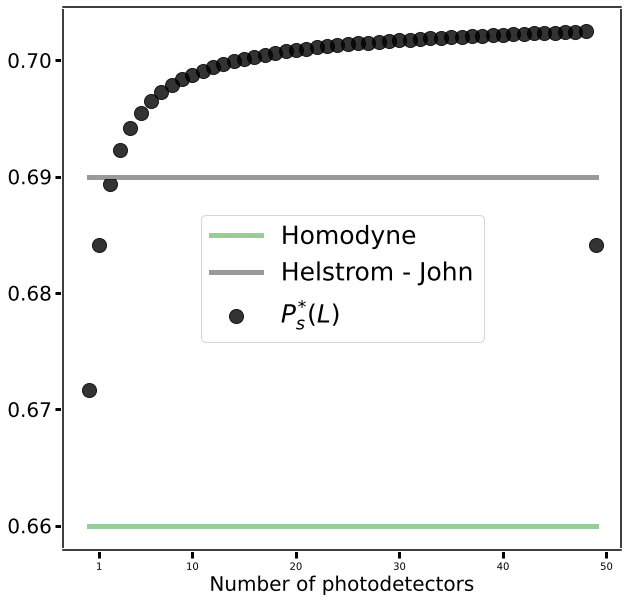

In [75]:
from helstrom import Helstrom
from math import erf

hel = Helstrom(alpha=0.4, ep = 0.01)
helstrom_avg = hel()


plt.xkcd(False)
plt.figure(figsize=(10,10))
plt.scatter(range(len(value)),value,alpha=0.8,color="black",s=200, label="$P^{*}_{s}(L)$")
ticks=[1, 10, 20, 30, 40, 50]
plt.xticks(ticks,[str(t) for t in ticks],size=10)
plt.xlabel("Number of photodetectors",size=20)
plt.yticks(size=20)
plt.plot(range(len(value)), np.ones(len(value))*homodyne(0.4,ep=0.01), linewidth=5, color="green",alpha=0.4, label="Homodyne")
plt.plot(range(len(value)), np.ones(len(value))*0.69, color="black", linewidth=5,alpha=0.4, label="Helstrom - John")
plt.legend(prop={"size":25}, loc="best")
plt.savefig("problema.png")
#plt.title(r'$\alpha = 0.4$'+"\n"+r'$\epsilon = 0.01$', size=30)
#plt.savefig("figures_iee/comparison_fixed_energy_and_damping.pdf")

In [61]:
def helly(amplitude):
    return (1 + np.sqrt(1-np.exp(-4*(amplitude**2))))/2

In [62]:
amplitude = 0.4
helly(amplitude)

0.8437686634776909

In [63]:
hel = Helstrom(alpha=0.4, ep = 0.01)
helstrom_avg = hel()
helstrom_avg

0.7222374638505551

In [58]:
hel.alpha

0.4